# Ingeniería de Características para Segmentación de la Calidad del Agua Subterránea

### Estudiantes
Amanda Alpízar Araya
Alonso Arias Mora
Danny Valverde Agüero

### Introducción y Objetivos

Esta sección detalla el proceso de ingeniería de características para el conjunto de datos sobre la calidad del agua de 1,068 sitios de monitoreo de aguas subterráneas en México. El objetivo es transformar los datos crudos en un formato optimizado para algoritmos de clustering no supervisado, maximizando la información relevante mientras se mitigan problemas como el sesgo, la alta dimensionalidad y la multicolinealidad.

El proceso de ingeniería de características se basa en hallazgos clave del Análisis Exploratorio de Datos (EDA), que reveló:
1. **Distribuciones altamente sesgadas** en variables fisicoquímicas que requieren transformaciones no lineales
2. **Alta correlación entre variables de salinidad** (CONDUCT_mS/cm y SDT_M_mg/L)
3. **Patrones geográficos significativos** que sugieren relaciones espaciales importantes
4. **Variables categóricas de alta cardinalidad** (MUNICIPIO: 452, ACUIFERO: 273)
5. **Indicadores multi-parámetro** de calidad del agua que podrían beneficiarse de características compuestas

La metodología implementada sigue un enfoque sistemático que incluye:
1. **Análisis de correlación** para la selección de características no redundantes
2. **Generación de características compuestas** basadas en conocimiento de dominio
3. **Transformaciones logarítmicas** para mitigar el sesgo
4. **Estandarización** para uniformizar escalas
5. **Reducción de dimensionalidad** para capturar patrones subyacentes

El resultado final será un conjunto de datos optimizado para algoritmos de clustering, que facilitará la identificación de perfiles significativos de calidad del agua.

### Sección 1: Configuración del Entorno y Carga de Datos

#### Resumen Ejecutivo de la Sección

El objetivo de esta sección inicial es configurar el entorno de trabajo necesario para la ingeniería de características y cargar el conjunto de datos limpio producido durante la fase de EDA. Importaremos las librerías esenciales para análisis de datos, visualización y transformaciones, y configuraremos el estilo visual para mantener consistencia con el análisis exploratorio.

La configuración incluye la supresión de advertencias para mantener una salida limpia y la definición de parámetros estándar para visualizaciones. Luego, cargaremos el dataset previamente limpiado (`df_cleaned.csv`), que contiene 1,068 registros con mediciones de calidad del agua y variables categóricas ya procesadas.

Esta sección establece la base para todo el proceso de ingeniería de características, asegurando que partimos de datos confiables y con un entorno de trabajo optimizado.

In [3]:
# --- Configuración del Entorno y Carga de Datos Limpios ---

# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform

# Ignorar advertencias para una salida limpia
warnings.filterwarnings("ignore")

# Configurar el estilo y tamaño de las gráficas
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# --- 1. Cargar el conjunto de datos limpio ---
# Este archivo es el resultado del notebook EDA.ipynb
cleaned_data_path = 'datos/df_cleaned.csv'
try:
    # Asumimos que el df_cleaned fue guardado con su índice, por lo que lo usamos como index_col
    df_cleaned = pd.read_csv(cleaned_data_path, index_col=0)
    print(f"El conjunto de datos limpio se cargó exitosamente desde: '{cleaned_data_path}'.")
    print(f"Dimensiones del dataset: {df_cleaned.shape}")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en la ruta: '{cleaned_data_path}'")
    print("Por favor, ejecute primero el notebook EDA.ipynb para generar este archivo.")
    df_cleaned = None

# --- 2. Mostrar información inicial del DataFrame ---
if df_cleaned is not None:
    print("\n--- Primeras 5 filas del conjunto de datos limpio ---")
    display(df_cleaned.head())
    print("\n--- Tipos de datos de las columnas ---")
    df_cleaned.info()

El conjunto de datos limpio se cargó exitosamente desde: 'datos/df_cleaned.csv'.
Dimensiones del dataset: (1068, 55)

--- Primeras 5 filas del conjunto de datos limpio ---


,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,ALC_mg/L,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
CLAVE,,,,,,,,,,,,,,,,,,,,,
DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,229.990,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,231.990,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,204.920,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,327.000,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,309.885,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI



--- Tipos de datos de las columnas ---
<class 'pandas.core.frame.DataFrame'>
Index: 1068 entries, DLAGU6 to OCRBR5109M1
Data columns (total 55 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   SITIO                 1068 non-null   object 
 1   ORGANISMO_DE_CUENCA   1068 non-null   object 
 2   ESTADO                1068 non-null   object 
 3   MUNICIPIO             1068 non-null   object 
 4   ACUIFERO              1068 non-null   object 
 5   SUBTIPO               1068 non-null   object 
 6   LONGITUD              1068 non-null   float64
 7   LATITUD               1068 non-null   float64
 8   PERIODO               1068 non-null   int64  
 9   ALC_mg/L              1068 non-null   float64
 10  CALIDAD_ALC           1068 non-null   object 
 11  CONDUCT_mS/cm         1068 non-null   float64
 12  CALIDAD_CONDUC        1068 non-null   object 
 13  SDT_M_mg/L            1068 non-null   float64
 14  CALIDAD_SDT_ra        106

### Sección 2: Análisis de Correlación y Selección de Características

#### Resumen Ejecutivo de la Sección

Esta sección aborda uno de los principales desafíos identificados en el EDA: la redundancia de información entre variables altamente correlacionadas. El objetivo es identificar y eliminar sistemáticamente esta redundancia para:
1. Reducir la dimensionalidad innecesaria
2. Evitar que el algoritmo de clustering asigne peso excesivo a información duplicada
3. Mejorar la eficiencia computacional sin pérdida significativa de información

La metodología implementada consiste en:
1. Seleccionar inicialmente todas las variables de medición para su análisis
2. Calcular la matriz de correlación absoluta entre estas variables
3. Identificar pares de variables con correlación superior a un umbral definido (r ≥ 0.8)
4. Aplicar un algoritmo para determinar qué variable de cada par debe conservarse

El criterio de selección dentro de cada par altamente correlacionado prioriza la variable con menos valores faltantes originalmente, lo que generalmente indica mayor confiabilidad en la medición.

Al final de esta sección, obtendremos un conjunto optimizado de variables para las siguientes etapas del proceso de ingeniería de características.

--- Análisis de Correlación para Selección de Características ---

Seleccionando variables de medición para análisis de correlación...
Se analizarán 14 variables de medición.

Calculando matriz de correlación...


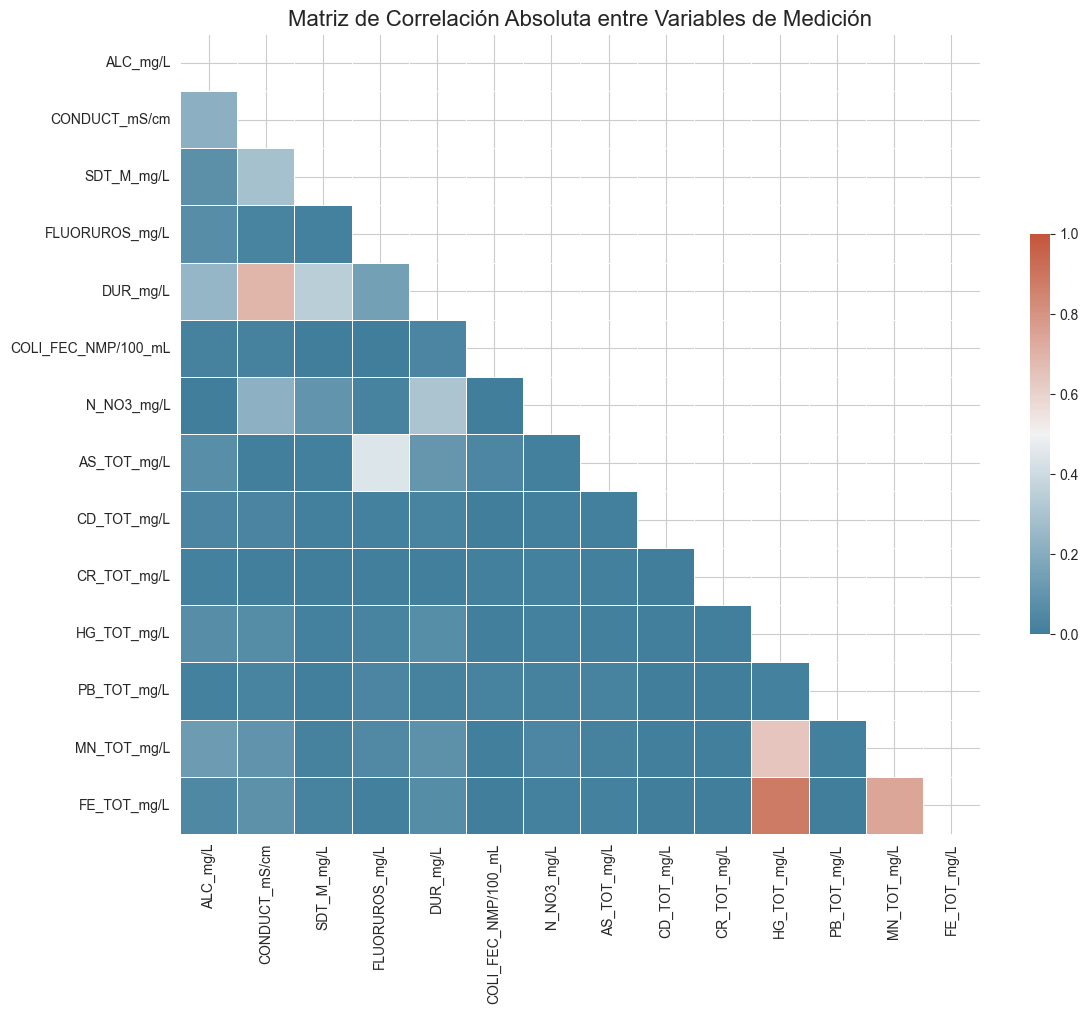


Se encontraron 1 pares de variables con alta correlación (r ≥ 0.8):
  - HG_TOT_mg/L y FE_TOT_mg/L: r = 0.8786

Se eliminarán 1 variables debido a alta correlación:
  - FE_TOT_mg/L

Se conservarán 13 variables de medición:
  - ALC_mg/L
  - CONDUCT_mS/cm
  - SDT_M_mg/L
  - FLUORUROS_mg/L
  - DUR_mg/L
  - COLI_FEC_NMP/100_mL
  - N_NO3_mg/L
  - AS_TOT_mg/L
  - CD_TOT_mg/L
  - CR_TOT_mg/L
  - HG_TOT_mg/L
  - PB_TOT_mg/L
  - MN_TOT_mg/L


In [ ]:
# --- Sección 2: Análisis de Correlación y Selección de Características ---

if df_cleaned is not None:
    print("--- Análisis de Correlación para Selección de Características ---\n")

    # Seleccionar todas las columnas de mediciones físico-químicas para análisis
    measurement_cols = [
        'ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_M_mg/L', 'FLUORUROS_mg/L',
        'DUR_mg/L', 'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 'AS_TOT_mg/L',
        'CD_TOT_mg/L', 'CR_TOT_mg/L', 'HG_TOT_mg/L', 'PB_TOT_mg/L',
        'MN_TOT_mg/L', 'FE_TOT_mg/L'
    ]

    geo_cols = ['LONGITUD', 'LATITUD']

    print(f"Seleccionando variables de medición para análisis de correlación...")
    print(f"Se analizarán {len(measurement_cols)} variables de medición.\n")

    # Calcular matriz de correlación
    print("Calculando matriz de correlación...")
    corr_matrix = df_cleaned[measurement_cols].corr().abs()

    # Visualizar la matriz de correlación
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, vmin=0,
                center=0.5, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.title('Matriz de Correlación Absoluta entre Variables de Medición', fontsize=16)
    plt.tight_layout()
    plt.show()

    # Identificar pares de variables altamente correlacionadas
    threshold = 0.8
    high_corr_pairs = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] >= threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    # Mostrar pares altamente correlacionados
    if high_corr_pairs:
        print(f"\nSe encontraron {len(high_corr_pairs)} pares de variables con alta correlación (r ≥ {threshold}):")
        for col1, col2, corr in high_corr_pairs:
            print(f"  - {col1} y {col2}: r = {corr:.4f}")

        # Algoritmo para seleccionar qué variables eliminar
        features_to_drop = set()
        for col1, col2, _ in high_corr_pairs:
            # Determinar cuál variable tenía originalmente más valores faltantes
            missing_col1 = df_cleaned[col1].isna().sum()
            missing_col2 = df_cleaned[col2].isna().sum()

            # Elegir la variable con más valores faltantes para eliminar
            if missing_col1 > missing_col2:
                features_to_drop.add(col1)
            else:
                features_to_drop.add(col2)

        print(f"\nSe eliminarán {len(features_to_drop)} variables debido a alta correlación:")
        for feature in features_to_drop:
            print(f"  - {feature}")

        # Actualizar la lista de variables seleccionadas
        selected_measurements = [col for col in measurement_cols if col not in features_to_drop]
        print(f"\nSe conservarán {len(selected_measurements)} variables de medición:")
        for feature in selected_measurements:
            print(f"  - {feature}")
    else:
        print(f"\nNo se encontraron pares de variables con correlación mayor o igual a {threshold}")
        selected_measurements = measurement_cols

    # Crear un DataFrame con las variables seleccionadas
    df_selected = df_cleaned[geo_cols + selected_measurements].copy()

### Sección 3: Generación de Características Compuestas

#### Resumen Ejecutivo de la Sección

En esta sección aplicamos el proceso de ingeniería de características para crear nuevas variables que capturen información más compleja y relevante que las mediciones individuales originales. El objetivo es desarrollar características compuestas que:

1. Integren múltiples dimensiones de la calidad del agua en métricas unificadas
2. Capturen relaciones entre contaminantes que son significativas para la interpretación
3. Reflejen patrones geográficos y contextuales que podrían influir en la agrupación

Basándonos en el conocimiento del dominio extraído del EDA, generamos tres tipos de características compuestas:

1. **Índice de Calidad del Agua**: Un indicador ponderado que integra los principales contaminantes según su importancia relativa para la salud y el uso del agua.

2. **Indicadores Regionales**: Características que capturan la proximidad geográfica entre puntos de monitoreo, lo que permite identificar patrones espaciales.

3. **Ratios de Balance Mineral**: Relaciones entre diferentes parámetros que son relevantes para evaluar el equilibrio químico del agua.

Estas características compuestas proporcionarán información adicional que las mediciones individuales no pueden capturar por sí solas, mejorando así la capacidad del algoritmo de clustering para identificar patrones significativos.

--- Generación de Características Compuestas ---

1. Creando índice de calidad del agua ponderado...
2. Creando indicadores regionales basados en proximidad geográfica...
3. Calculando ratios de balance mineral...

Se han generado 4 nuevas características compuestas:
  - indice_calidad_agua
  - distancia_vecino_cercano
  - ratio_conduct_dureza
  - ratio_alc_dureza

Estadísticas descriptivas de las nuevas características:


,indice_calidad_agua,distancia_vecino_cercano,ratio_conduct_dureza,ratio_alc_dureza
count,1068.000000,1068.000000,1068.000000,1068.000000
mean,0.143119,0.103569,5.105038,1.496299
std,0.108321,0.117509,7.327869,2.529895
min,0.001674,0.000000,0.406223,0.013307
25%,0.060166,0.028784,2.481197,0.563596
50%,0.115563,0.069075,3.208809,0.940613
75%,0.196610,0.133980,4.695059,1.473893
max,0.636023,0.940715,98.445078,34.052797


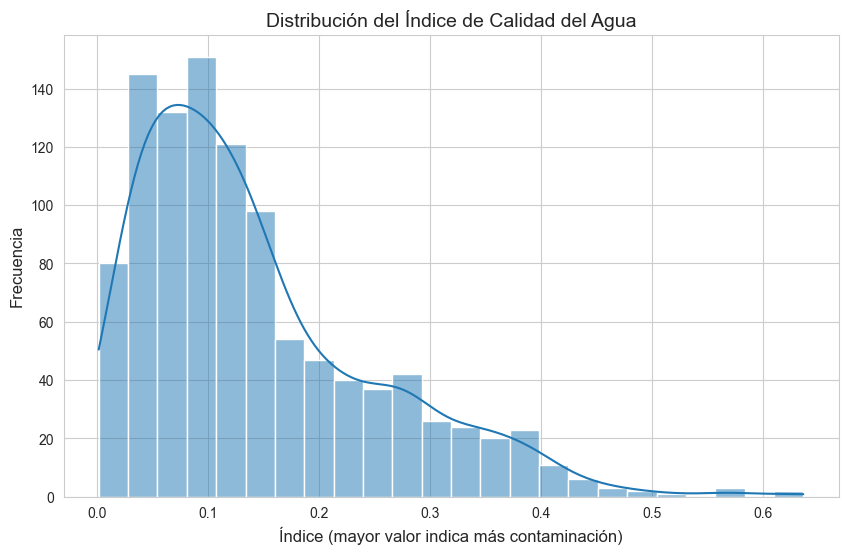

In [ ]:
# --- Sección 3: Generación de Características Compuestas ---

if df_cleaned is not None:
    print("--- Generación de Características Compuestas ---\n")

    # Crear copia para generación de características
    df_features = df_selected.copy()

    # 1. Crear índice de calidad del agua ponderado
    print("1. Creando índice de calidad del agua ponderado...")

    # Definir pesos basados en la importancia para la salud y calidad del agua
    # Estos pesos se basan en el análisis del EDA y la frecuencia de contaminantes
    weights = {
        'AS_TOT_mg/L': 0.20,      # Alto impacto en salud humana
        'FLUORUROS_mg/L': 0.15,   # Impacto significativo en salud
        'N_NO3_mg/L': 0.15,       # Importante para calidad de agua potable
        'CONDUCT_mS/cm': 0.10,    # Indicador de mineralización
        'FE_TOT_mg/L': 0.10,      # Contaminante común
        'MN_TOT_mg/L': 0.10,      # Contaminante común
        'COLI_FEC_NMP/100_mL': 0.20  # Indicador crítico de contaminación biológica
    }

    # Normalizar cada parámetro al rango [0,1] usando percentiles para reducir influencia de outliers
    normalized_params = {}
    for param, weight in weights.items():
        if param in df_features.columns:
            q_min, q_max = df_features[param].quantile([0.05, 0.95])
            normalized = (df_features[param] - q_min) / (q_max - q_min)
            normalized = normalized.clip(0, 1)  # Limitar valores a [0,1]
            normalized_params[param] = normalized

    # Calcular el índice ponderado
    df_features['indice_calidad_agua'] = sum(
        normalized_params[param] * weight
        for param, weight in weights.items()
        if param in normalized_params
    )

    # 2. Crear indicadores regionales basados en proximidad geográfica
    print("2. Creando indicadores regionales basados en proximidad geográfica...")

    # Calcular matriz de distancias entre todos los puntos
    coords = df_features[['LONGITUD', 'LATITUD']].values
    distances = pdist(coords)  # Distancia euclidiana entre todos los pares de puntos
    dist_matrix = squareform(distances)  # Convertir a matriz

    # Calcular distancia al vecino más cercano
    df_features['distancia_vecino_cercano'] = [
        sorted(dist_matrix[i])[1] for i in range(len(dist_matrix))
    ]

    # 3. Calcular ratios de balance mineral
    print("3. Calculando ratios de balance mineral...")

    # Ratio de conductividad a dureza (proxy de SAR - Sodium Adsorption Ratio)
    if 'CONDUCT_mS/cm' in df_features.columns and 'DUR_mg/L' in df_features.columns:
        df_features['ratio_conduct_dureza'] = df_features['CONDUCT_mS/cm'] / (df_features['DUR_mg/L'] + 0.001)

    # Ratio de alcalinidad a dureza (equilibrio carbonato-calcio)
    if 'ALC_mg/L' in df_features.columns and 'DUR_mg/L' in df_features.columns:
        df_features['ratio_alc_dureza'] = df_features['ALC_mg/L'] / (df_features['DUR_mg/L'] + 0.001)

    # Mostrar resumen de las nuevas características generadas
    new_features = [col for col in df_features.columns if col not in df_selected.columns]

    print(f"\nSe han generado {len(new_features)} nuevas características compuestas:")
    for feature in new_features:
        print(f"  - {feature}")

    # Mostrar estadísticas descriptivas de las nuevas características
    print("\nEstadísticas descriptivas de las nuevas características:")
    display(df_features[new_features].describe())

    # Visualizar la distribución del índice de calidad del agua
    plt.figure(figsize=(10, 6))
    sns.histplot(df_features['indice_calidad_agua'], kde=True)
    plt.title('Distribución del Índice de Calidad del Agua', fontsize=14)
    plt.xlabel('Índice (mayor valor indica más contaminación)', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.show()

### Sección 4: Transformación y Normalización de Datos

#### Resumen Ejecutivo de la Sección

En esta sección abordamos uno de los hallazgos más importantes del EDA: la distribución altamente sesgada de la mayoría de las variables de medición. Estas distribuciones no normales pueden afectar negativamente el rendimiento de los algoritmos de clustering, especialmente aquellos basados en distancias euclidianas.

El proceso de transformación consta de dos etapas principales:

1. **Transformación Logarítmica**: Aplicamos la transformación logarítmica (log1p) a todas las variables de medición excepto las coordenadas geográficas. Esta transformación reduce el sesgo positivo, comprime el rango de valores extremos y aproxima las distribuciones a la normalidad. Utilizamos log1p (logaritmo de x+1) en lugar del logaritmo simple para manejar adecuadamente los valores cercanos o iguales a cero.

2. **Estandarización**: Aplicamos la estandarización (z-score) a todas las variables, incluidas las geográficas, para que todas tengan media cero y desviación estándar uno. Esto garantiza que todas las variables contribuyan por igual al análisis de clustering independientemente de sus escalas originales.

Estas transformaciones son esenciales para la efectividad del clustering, ya que los algoritmos basados en distancia (como K-means) son sensibles a las diferencias en escalas y a las distribuciones sesgadas. Al normalizar y estandarizar los datos, aseguramos que el algoritmo capture correctamente los patrones subyacentes sin estar indebidamente influenciado por valores extremos o diferencias de escala.

--- Transformación y Normalización de Datos ---

1. Aplicando transformación logarítmica...
Se transformarán 13 variables:
  - ALC_mg/L
  - CONDUCT_mS/cm
  - SDT_M_mg/L
  - FLUORUROS_mg/L
  - DUR_mg/L
  ... y 8 más


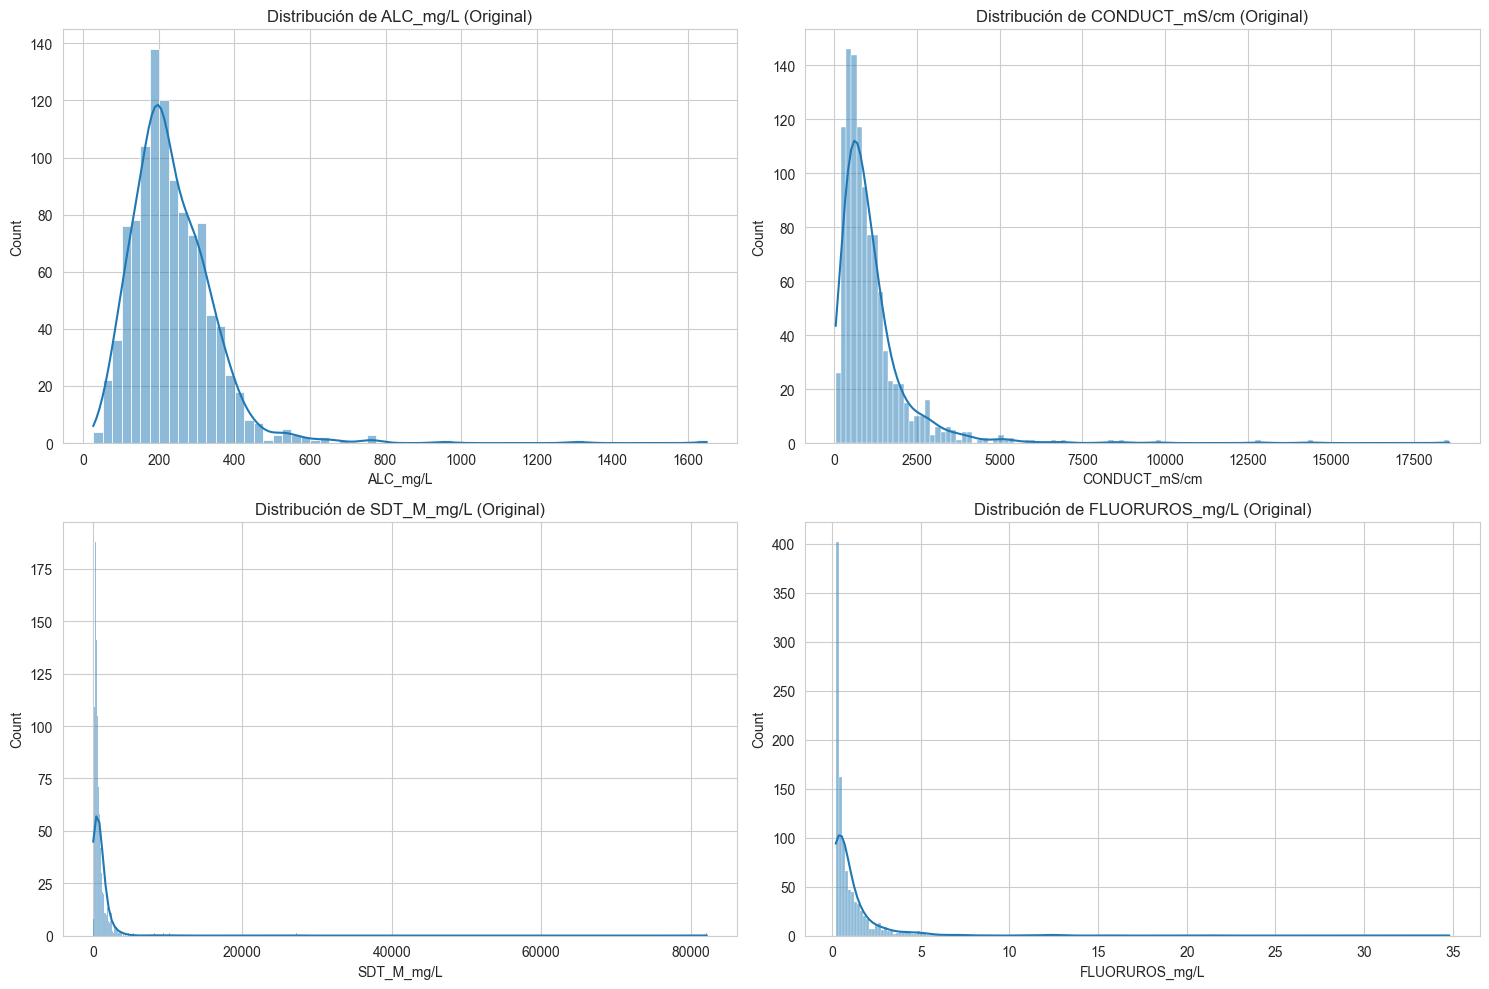

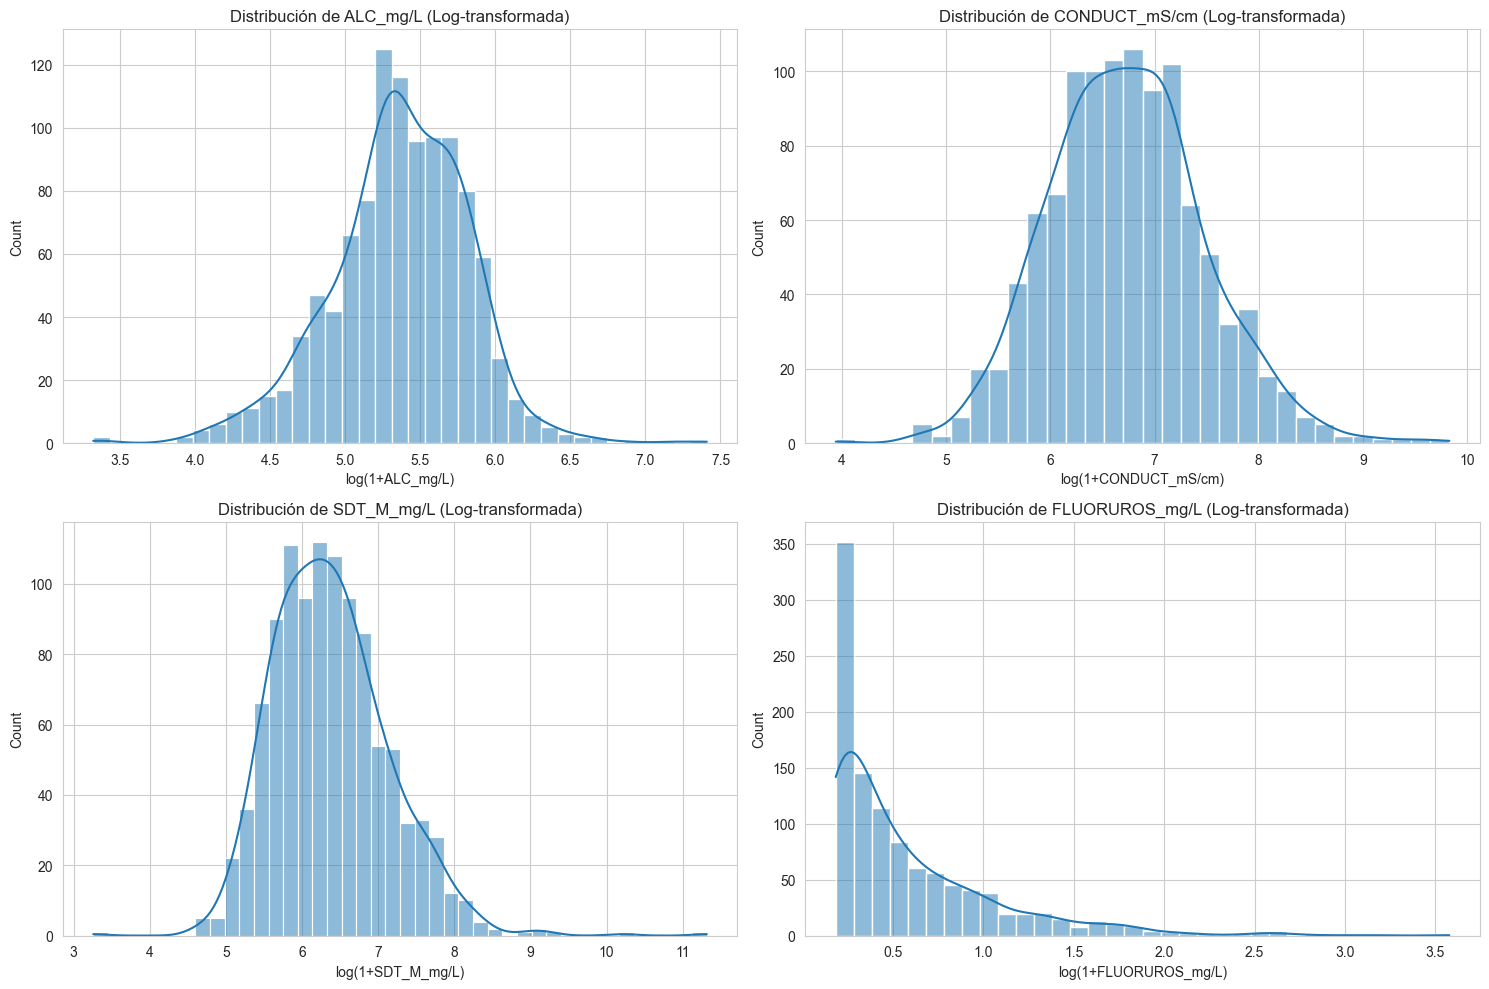


2. Aplicando estandarización (z-score) a todas las variables...

Primeras filas de los datos transformados y escalados:


,LONGITUD,LATITUD,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,indice_calidad_agua,distancia_vecino_cercano,ratio_conduct_dureza,ratio_alc_dureza
CLAVE,,,,,,,,,,,,,,,,,,,
DLAGU6,-0.019566,-0.245699,0.170498,0.154332,0.034412,0.224592,-0.069112,-0.569333,0.503313,-0.093870,-0.033251,-0.087795,-0.12336,-0.087343,-0.27479,-0.174718,-0.247699,-0.096530,-0.166186
DLAGU6516,-0.046229,-0.299558,0.189358,-0.429214,-0.361979,0.173156,-0.218878,-0.569333,0.802516,-0.178972,-0.033251,-0.087795,-0.12336,-0.087343,-0.27479,-0.241290,-0.043415,-0.248413,-0.095960
DLAGU7,-0.059253,-0.205043,-0.080839,-0.607978,-0.706276,0.975569,-0.662124,-0.569333,-0.346819,0.557335,-0.033251,-0.087795,-0.12336,-0.087343,-0.27479,0.404826,-0.174208,-0.095317,0.079560
DLAGU9,-0.060220,-0.252009,0.937587,-0.267590,-0.268240,0.377869,-0.138776,-0.569333,-0.438969,-0.115912,-0.033251,-0.087795,-0.12336,-0.087343,-0.27479,-0.519086,0.672996,-0.228411,0.055239
DLBAJ107,-1.246812,0.074054,0.820348,1.055100,0.908209,-0.786180,0.766796,1.695732,1.827835,-0.286461,-0.033251,-0.087795,-0.12336,-0.087343,-0.27479,1.109592,-0.646165,-0.170034,-0.334806



Verificación de la estandarización (valores cercanos a 0 y 1 respectivamente):


,Media,Desviación Estándar
LONGITUD,1.290686e-15,1.000468
LATITUD,3.592632e-16,1.000468
ALC_mg/L,1.255758e-15,1.000468
CONDUCT_mS/cm,-2.661209e-16,1.000468
SDT_M_mg/L,3.393041e-16,1.000468
FLUORUROS_mg/L,9.314231e-17,1.000468
DUR_mg/L,5.987720e-17,1.000468
COLI_FEC_NMP/100_mL,3.991813e-17,1.000468
N_NO3_mg/L,1.463665e-16,1.000468
AS_TOT_mg/L,5.322417e-17,1.000468


In [ ]:
# --- Sección 4: Transformación y Normalización de Datos ---

if df_cleaned is not None:
    print("--- Transformación y Normalización de Datos ---\n")

    # Crear copia para transformaciones
    df_transform = df_features.copy()

    # 1. Transformación logarítmica para variables con distribución sesgada
    # Excluir coordenadas geográficas y las características ya generadas
    skip_cols = ['LONGITUD', 'LATITUD', 'indice_calidad_agua', 'distancia_vecino_cercano',
                 'ratio_conduct_dureza', 'ratio_alc_dureza']
    log_transform_cols = [col for col in df_transform.columns if col not in skip_cols]

    print("1. Aplicando transformación logarítmica...")
    print(f"Se transformarán {len(log_transform_cols)} variables:")
    for col in log_transform_cols[:5]:
        print(f"  - {col}")
    if len(log_transform_cols) > 5:
        print(f"  ... y {len(log_transform_cols)-5} más")

    # Visualizar distribuciones antes de la transformación (muestra de 4 variables)
    sample_cols = [col for col in log_transform_cols if col in selected_measurements][:4]
    if sample_cols:
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(sample_cols):
            plt.subplot(2, 2, i+1)
            sns.histplot(df_transform[col], kde=True)
            plt.title(f'Distribución de {col} (Original)', fontsize=12)
            plt.xlabel(col)
        plt.tight_layout()
        plt.show()

    # Aplicar transformación logarítmica
    for col in log_transform_cols:
        df_transform[col] = np.log1p(df_transform[col])

    # Visualizar distribuciones después de la transformación
    if sample_cols:
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(sample_cols):
            plt.subplot(2, 2, i+1)
            sns.histplot(df_transform[col], kde=True)
            plt.title(f'Distribución de {col} (Log-transformada)', fontsize=12)
            plt.xlabel(f'log(1+{col})')
        plt.tight_layout()
        plt.show()

    # 2. Estandarización (z-score) de todas las variables
    print("\n2. Aplicando estandarización (z-score) a todas las variables...")

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_transform)

    # Crear DataFrame con datos escalados
    df_scaled = pd.DataFrame(
        scaled_data,
        index=df_transform.index,
        columns=df_transform.columns
    )

    # Mostrar primeras filas de los datos transformados y escalados
    print("\nPrimeras filas de los datos transformados y escalados:")
    display(df_scaled.head())

    # Verificar que la estandarización funcionó correctamente
    mean_std = pd.DataFrame({
        'Media': df_scaled.mean(),
        'Desviación Estándar': df_scaled.std()
    })

    print("\nVerificación de la estandarización (valores cercanos a 0 y 1 respectivamente):")
    display(mean_std)

### Sección 5: Reducción de Dimensionalidad con PCA

#### Resumen Ejecutivo de la Sección

Esta sección implementa la reducción de dimensionalidad mediante Análisis de Componentes Principales (PCA), una técnica esencial para preparar datos de alta dimensionalidad para algoritmos de clustering. La aplicación de PCA tiene varios objetivos fundamentales:

1. **Reducir la complejidad del modelo** manteniendo la máxima varianza posible
2. **Mitigar el problema de la maldición de la dimensionalidad**, que afecta negativamente a los algoritmos basados en distancias
3. **Eliminar la multicolinealidad residual** que pudiera persistir incluso después del análisis de correlación
4. **Facilitar la visualización** de los datos en espacios de menor dimensión

El enfoque implementado consiste en:
1. Aplicar PCA configurado para capturar al menos el 90% de la varianza total
2. Analizar la cantidad de componentes necesarias y su contribución individual a la varianza explicada
3. Examinar la composición de cada componente principal para comprender qué variables originales influyen más en cada una
4. Conservar tanto la matriz de datos transformada como la información de importancia de variables

Este paso proporciona un conjunto de datos optimizado para el clustering, donde cada componente principal representa una combinación lineal de las variables originales, capturando diferentes aspectos de la variabilidad de los datos de calidad del agua.

--- Reducción de Dimensionalidad con PCA ---

Aplicando PCA para capturar al menos el 90% de la varianza...

Se identificaron 12 componentes principales que explican el 91.32% de la varianza total


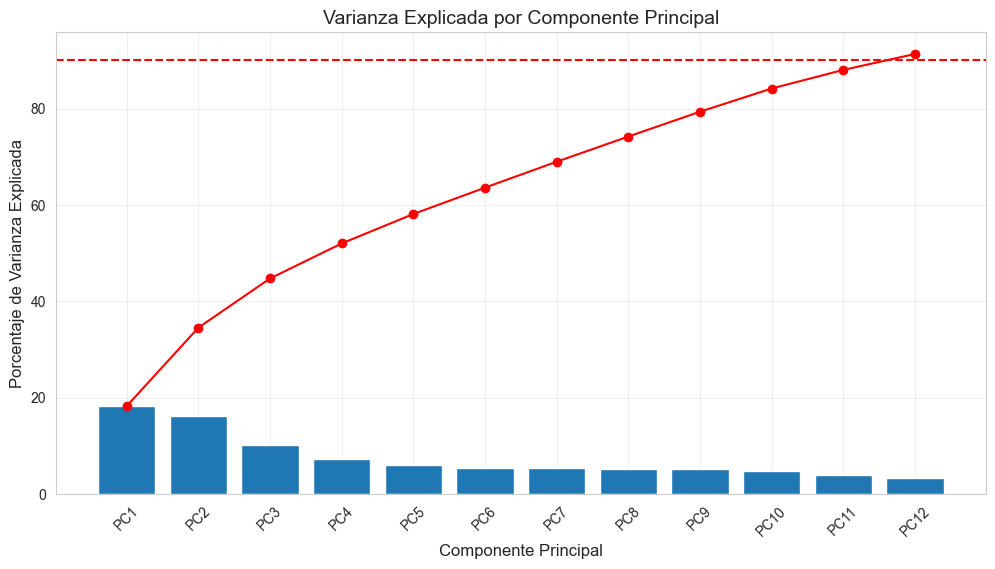


Contribución de cada componente principal a la varianza total:
  - PC1: 18.26% varianza (18.26% acumulada)
  - PC2: 16.27% varianza (34.53% acumulada)
  - PC3: 10.21% varianza (44.74% acumulada)
  - PC4: 7.26% varianza (52.01% acumulada)
  - PC5: 6.11% varianza (58.11% acumulada)
  - PC6: 5.47% varianza (63.58% acumulada)
  - PC7: 5.38% varianza (68.97% acumulada)
  - PC8: 5.22% varianza (74.19% acumulada)
  - PC9: 5.15% varianza (79.34% acumulada)
  - PC10: 4.82% varianza (84.16% acumulada)
  - PC11: 3.86% varianza (88.02% acumulada)
  - PC12: 3.31% varianza (91.32% acumulada)

Variables más influyentes en los primeros componentes principales:

  PC1 (18.26% varianza):
    - DUR_mg/L: 0.5122
    - SDT_M_mg/L: 0.4258
    - CONDUCT_mS/cm: 0.4165

  PC2 (16.27% varianza):
    - indice_calidad_agua: 0.4704
    - FLUORUROS_mg/L: 0.3745
    - ratio_conduct_dureza: 0.3603

  PC3 (10.21% varianza):
    - LONGITUD: 0.5581
    - LATITUD: 0.5296
    - ALC_mg/L: 0.3240


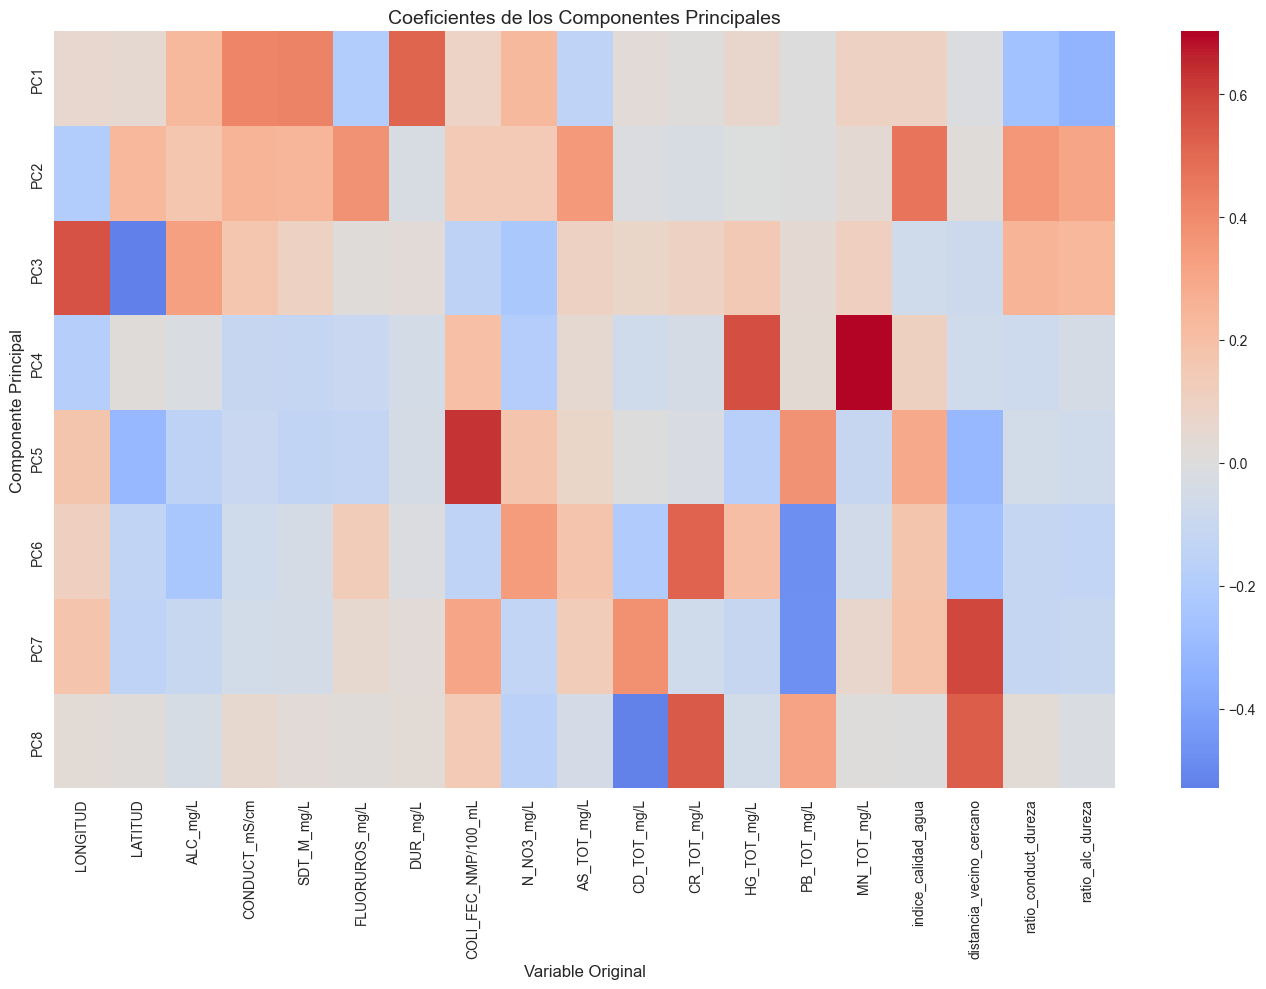


Primeras filas de los datos transformados con PCA:


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
CLAVE,,,,,,,,,,,,
DLAGU6,0.133213,-0.115718,0.073919,-0.501410,-0.209376,0.312877,-0.359096,-0.343302,-0.070416,0.267772,0.056482,0.228514
DLAGU6516,-0.256146,-0.421989,-0.158168,-0.443071,-0.109092,0.395584,-0.241711,-0.333593,-0.069275,0.472465,-0.094549,0.601502
DLAGU7,-1.323095,0.246213,0.015580,-0.122662,-0.058175,0.433417,0.080939,-0.258500,-0.127099,0.173720,0.755197,0.669155
DLAGU9,-0.358594,-0.371253,0.377876,-0.358103,-0.828406,-0.451384,0.188771,0.230132,-0.188650,-0.011803,0.113071,0.966519
DLBAJ107,2.345242,1.314694,-1.096691,-0.059497,1.430652,0.178914,-0.285722,-0.401620,-0.082044,-0.374550,-1.139193,0.118039


In [ ]:
# --- Sección 5: Reducción de Dimensionalidad con PCA ---

if df_cleaned is not None:
    print("--- Reducción de Dimensionalidad con PCA ---\n")

    # Aplicar PCA configurado para capturar al menos el 90% de la varianza
    print("Aplicando PCA para capturar al menos el 90% de la varianza...")
    pca = PCA(n_components=0.90)
    pca_result = pca.fit_transform(df_scaled)

    # Crear DataFrame con los componentes principales
    pca_cols = [f'PC{i+1}' for i in range(pca_result.shape[1])]
    df_pca = pd.DataFrame(
        pca_result,
        index=df_scaled.index,
        columns=pca_cols
    )

    # Analizar la varianza explicada
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    print(f"\nSe identificaron {len(pca_cols)} componentes principales que explican el {cumulative_variance[-1]*100:.2f}% de la varianza total")

    # Visualizar la varianza explicada por cada componente
    plt.figure(figsize=(12, 6))
    plt.bar(pca_cols, explained_variance * 100)
    plt.plot(pca_cols, cumulative_variance * 100, 'ro-')
    plt.axhline(y=90, color='r', linestyle='--')
    plt.title('Varianza Explicada por Componente Principal', fontsize=14)
    plt.xlabel('Componente Principal', fontsize=12)
    plt.ylabel('Porcentaje de Varianza Explicada', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.show()

    # Mostrar la contribución de cada componente principal
    print("\nContribución de cada componente principal a la varianza total:")
    for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
        print(f"  - PC{i+1}: {var*100:.2f}% varianza ({cum_var*100:.2f}% acumulada)")

    # Analizar la composición de los primeros componentes principales
    components_df = pd.DataFrame(
        pca.components_,
        columns=df_scaled.columns,
        index=pca_cols
    )

    # Mostrar las 3 variables más influyentes para cada uno de los primeros 3 componentes
    print("\nVariables más influyentes en los primeros componentes principales:")
    for i in range(min(3, len(pca_cols))):
        comp = components_df.iloc[i].abs()
        top_vars = comp.nlargest(3)
        print(f"\n  PC{i+1} ({explained_variance[i]*100:.2f}% varianza):")
        for var, weight in top_vars.items():
            print(f"    - {var}: {weight:.4f}")

    # Visualizar mapa de calor de la matriz de componentes
    plt.figure(figsize=(14, 10))
    sns.heatmap(components_df.iloc[:min(8, len(pca_cols))], cmap='coolwarm', center=0)
    plt.title('Coeficientes de los Componentes Principales', fontsize=14)
    plt.ylabel('Componente Principal', fontsize=12)
    plt.xlabel('Variable Original', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # Mostrar las primeras filas de los datos transformados con PCA
    print("\nPrimeras filas de los datos transformados con PCA:")
    display(df_pca.head())

### Sección 6: Preparación Final y Exportación de Datos

#### Resumen Ejecutivo de la Sección

Esta sección final completa el proceso de ingeniería de características preparando y exportando los conjuntos de datos optimizados para el análisis de clustering. El objetivo es proporcionar múltiples representaciones de los datos, cada una con diferentes ventajas según la técnica de clustering y los objetivos de análisis específicos.

Preparamos tres conjuntos de datos complementarios:

1. **Conjunto con todas las características escaladas**: Incluye todas las variables originales seleccionadas y las características compuestas, después de la transformación logarítmica y estandarización. Este conjunto conserva la interpretabilidad directa de las variables.

2. **Conjunto con componentes principales**: Contiene los componentes principales que capturan al menos el 90% de la varianza. Este conjunto es óptimo para algoritmos sensibles a la dimensionalidad y la multicolinealidad.

3. **Conjunto híbrido**: Combina coordenadas geográficas con componentes principales, preservando la información espacial explícita mientras se beneficia de la reducción de dimensionalidad para las variables fisicoquímicas.

Adicionalmente, exportamos la matriz de importancia de variables en los componentes principales, lo que facilitará la interpretación posterior de los resultados del clustering.

Esta estrategia flexible permite adaptar el enfoque de clustering según los resultados preliminares y proporciona múltiples perspectivas para la segmentación de la calidad del agua subterránea.

In [ ]:
# --- Sección 6: Preparación Final y Exportación de Datos ---

if df_cleaned is not None:
    print("--- Preparación Final y Exportación de Datos ---\n")

    # 1. Preparar conjunto de datos con todas las características escaladas
    final_df_all_features = df_scaled.copy()

    # 2. Conjunto de datos con componentes principales
    final_df_pca = df_pca.copy()

    # 3. Conjunto híbrido: coordenadas geográficas + componentes principales
    # Extraer coordenadas del conjunto escalado
    geo_scaled = df_scaled[['LONGITUD', 'LATITUD']]

    # Combinar con componentes principales
    final_df_hybrid = pd.concat([geo_scaled, df_pca], axis=1)

    # Resumen de los conjuntos de datos preparados
    print("Conjuntos de datos preparados para clustering:")
    print(f"1. Conjunto con todas las características escaladas: {final_df_all_features.shape} (filas x columnas)")
    print(f"2. Conjunto con componentes principales: {final_df_pca.shape} (filas x columnas)")
    print(f"3. Conjunto híbrido (geo + PCA): {final_df_hybrid.shape} (filas x columnas)")

    # Exportar conjuntos de datos a archivos CSV
    try:
        final_df_all_features.to_csv('datos/df_features_scaled.csv')
        final_df_pca.to_csv('datos/df_pca.csv')
        final_df_hybrid.to_csv('datos/df_hybrid.csv')

        # Exportar matriz de importancia de variables en componentes
        components_df.to_csv('datos/pca_components.csv')

        print("\nConjuntos de datos exportados exitosamente a la carpeta 'datos/'")
    except Exception as e:
        print(f"\nError al exportar los datos: {str(e)}")

    # Mostrar ejemplos de los tres conjuntos de datos
    print("\nEjemplo del conjunto con todas las características (primeras 3 filas):")
    display(final_df_all_features.head(3))

    print("\nEjemplo del conjunto con componentes principales (primeras 3 filas):")
    display(final_df_pca.head(3))

    print("\nEjemplo del conjunto híbrido (primeras 3 filas):")
    display(final_df_hybrid.head(3))

    print("\n--- Proceso de Ingeniería de Características Completado ---")
    print("Los datos están ahora optimizados para algoritmos de clustering.")

--- Preparación Final y Exportación de Datos ---

Conjuntos de datos preparados para clustering:
1. Conjunto con todas las características escaladas: (1068, 19) (filas x columnas)
2. Conjunto con componentes principales: (1068, 12) (filas x columnas)
3. Conjunto híbrido (geo + PCA): (1068, 14) (filas x columnas)

Conjuntos de datos exportados exitosamente a la carpeta 'datos/'

Ejemplo del conjunto con todas las características (primeras 3 filas):


,LONGITUD,LATITUD,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CD_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,indice_calidad_agua,distancia_vecino_cercano,ratio_conduct_dureza,ratio_alc_dureza
CLAVE,,,,,,,,,,,,,,,,,,,
DLAGU6,-0.019566,-0.245699,0.170498,0.154332,0.034412,0.224592,-0.069112,-0.569333,0.503313,-0.093870,-0.033251,-0.087795,-0.12336,-0.087343,-0.27479,-0.174718,-0.247699,-0.096530,-0.166186
DLAGU6516,-0.046229,-0.299558,0.189358,-0.429214,-0.361979,0.173156,-0.218878,-0.569333,0.802516,-0.178972,-0.033251,-0.087795,-0.12336,-0.087343,-0.27479,-0.241290,-0.043415,-0.248413,-0.095960
DLAGU7,-0.059253,-0.205043,-0.080839,-0.607978,-0.706276,0.975569,-0.662124,-0.569333,-0.346819,0.557335,-0.033251,-0.087795,-0.12336,-0.087343,-0.27479,0.404826,-0.174208,-0.095317,0.079560



Ejemplo del conjunto con componentes principales (primeras 3 filas):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
CLAVE,,,,,,,,,,,,
DLAGU6,0.133213,-0.115718,0.073919,-0.501410,-0.209376,0.312877,-0.359096,-0.343302,-0.070416,0.267772,0.056482,0.228514
DLAGU6516,-0.256146,-0.421989,-0.158168,-0.443071,-0.109092,0.395584,-0.241711,-0.333593,-0.069275,0.472465,-0.094549,0.601502
DLAGU7,-1.323095,0.246213,0.015580,-0.122662,-0.058175,0.433417,0.080939,-0.258500,-0.127099,0.173720,0.755197,0.669155



Ejemplo del conjunto híbrido (primeras 3 filas):


,LONGITUD,LATITUD,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
CLAVE,,,,,,,,,,,,,,
DLAGU6,-0.019566,-0.245699,0.133213,-0.115718,0.073919,-0.501410,-0.209376,0.312877,-0.359096,-0.343302,-0.070416,0.267772,0.056482,0.228514
DLAGU6516,-0.046229,-0.299558,-0.256146,-0.421989,-0.158168,-0.443071,-0.109092,0.395584,-0.241711,-0.333593,-0.069275,0.472465,-0.094549,0.601502
DLAGU7,-0.059253,-0.205043,-1.323095,0.246213,0.015580,-0.122662,-0.058175,0.433417,0.080939,-0.258500,-0.127099,0.173720,0.755197,0.669155



--- Proceso de Ingeniería de Características Completado ---
Los datos están ahora optimizados para algoritmos de clustering.


### Conclusiones de la Ingeniería de Características

El proceso de ingeniería de características implementado ha transformado el conjunto de datos original de calidad del agua subterránea en representaciones optimizadas para el análisis de clustering. Las mejoras clave incluyen:

1. **Eliminación de Redundancia**: A través del análisis de correlación, identificamos y eliminamos variables altamente correlacionadas, reduciendo la multicolinealidad que podría distorsionar los resultados del clustering.

2. **Generación de Características Informativas**: Creamos características compuestas que capturan aspectos multidimensionales de la calidad del agua, como el índice de calidad ponderado y ratios de balance mineral, incorporando conocimiento de dominio en el proceso.

3. **Normalización de Distribuciones**: Aplicamos transformaciones logarítmicas para mitigar el fuerte sesgo observado en el EDA, haciendo que las distribuciones sean más adecuadas para algoritmos basados en distancia.

4. **Estandarización de Escalas**: Implementamos la estandarización para asegurar que todas las variables contribuyan equitativamente al análisis, independientemente de sus unidades o rangos originales.

5. **Reducción Dimensionalidad Preservando Varianza**: Aplicamos PCA para reducir la dimensionalidad mientras preservamos al menos el 90% de la varianza total, facilitando un clustering más eficiente y robusto.

6. **Estrategia Flexible de Representación**: Generamos múltiples conjuntos de datos (completo, PCA e híbrido) que permiten diferentes enfoques de clustering según los objetivos específicos del análisis.

El resultado es un proceso de ingeniería de características sistemático, guiado por los hallazgos del EDA y orientado a optimizar la efectividad de los algoritmos de clustering para la segmentación de la calidad del agua subterránea.

Los conjuntos de datos resultantes están listos para ser utilizados en diferentes algoritmos de clustering como K-means, DBSCAN o agrupamiento jerárquico, permitiendo identificar patrones significativos en la calidad del agua subterránea de México.